# **Trabalho de LUI**

---




**Aluno:** Filipe Faria Rodrigues

**Matrícula:** 211101222

---



O trabalho consiste na obtenção dos valores dos preços da gasolina disponibilizados pela Petrobras em seu site, e a comparação com as cotações do dólar e do barril do petróleo (Brent) nas mesmas datas.

O trabalho foi dividido nas seguintes etapas:

1. Instalação das bibliotecas necessárias;
2. Download do arquivo pdf contendo o preço da gasolina vendido pela Petrobras (disponível no site https://precos.petrobras.com.br/);
3. Leitura do arquivo pdf e criação de um dataframe com os valores da gasolina;
4. Obtenção das cotações do dólar no período de análise, utilizando o json disponivel pelo Banco Central, inserindo as informações obtidas em um dataframe;
5. Obtenção das cotações do petróleo Brent, via scraping, no site https://www.eia.gov/dnav/pet/hist/RBRTED.htm, inserindo as informações obtidas em outro dataframe;
6. Criação de um dataframe final, consolidando as informações obtidas anteriormente;
7. Criação de um gráfico comparativo.

---
1. Instalação e importação das bibliotecas necessárias


In [1]:
#instalando a biblioteca PyPDF2
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 5.6 MB/s 


In [2]:
#instalando a biblioteca tabula
!pip install tabula-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 4.6 MB/s 


In [3]:
# instalando chromium, driver, e selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,866 kB]
Hit:13 http://ppa.launchpad.ne

In [4]:
#importar bibliotecas
import PyPDF2
import re
from tabula.io import read_pdf
import tabula
import pandas as pd
import requests
import json
import requests
from bs4 import BeautifulSoup
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver
from selenium.webdriver.common.by import By

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)




---


2. Download do arquivo pdf contendo preço da gasolina vendida pela Petrobras

In [5]:
#configurações driver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--start-maximized')
chrome_options.add_argument('--user-agent=Mozilla/5.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36') # TROCANDO O USER-AGENT Mozilla/5.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36
chrome_options.add_argument('--ignore-certificate-errors')
chrome_options.add_argument('--window-size=1024x768')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options, service_args=['--verbose', '--log-path=/tmp/chromedriver.log'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: use options instead of chrome_options
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#acessa o site
driver.get('https://precos.petrobras.com.br/')

In [7]:
#Aceitar cookies
try:
  driver.find_element(By.XPATH, '/html/body/div[1]/div[1]/section/div/div[7]/div/div[2]/div/div[2]/div[1]/span').click()
except:
  pass

In [8]:
#Clica no botão gasolina
driver.find_element(By.XPATH, '//*[@id="gasolina-tab-btn"]').click()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  


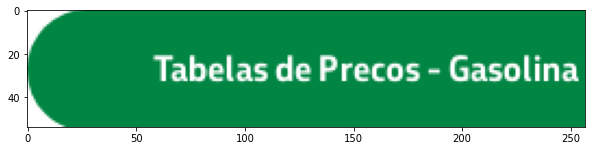

In [9]:
#verificando se está na página correta para o download (Botão Tabela de Preços - Gasolina)
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

figure = driver.find_element_by_xpath('//div[@class="card-Botao" and @data-dimensao="Gasolina"]').screenshot_as_png
im = Image.open(BytesIO(figure))
plt.figure(figsize=(10,6))
plt.imshow(im)
plt.show()

In [11]:
#clica em tabela de preços e faz o download
driver.find_element(By.XPATH, '//div[@class="card-Botao" and @data-dimensao="Gasolina"]').click()
print('Aguarde a conclusão do download para prosseguir para as etapas posteriores!')

Aguarde a conclusão do download para prosseguir para as etapas posteriores!




---


3. Leitura pdf - valor da gasolina

In [12]:
#Para o exercício, foi escolhida a localidade Duque de Caxias (RJ), 
#na modalidade de venda EXA (Entrega por duto a serviço da COMPRADORA, interligado ao Ponto “A” ou Flange de
#Interconexão dos Ativos, ambos dentro da Área Operacional da Unidade Fornecedora.)

#variaveis
dir_produto = 'Tabelas de Preços - Gasolina (1).pdf'
nome_produto = ' Preços de Gasolina A sem tributos'
local = 'Duque de Caxias (RJ)'
modalidade_venda = 'EXA'

In [13]:
#obtem os numeros das paginas a serem lidas no pdf

def get_pages_gasolina(dir_produto, nome_produto):
    pages_produto = []
    #lê o arquivo pdf
    pdfFileObj = open(dir_produto,'rb') 
    pdfReader = PyPDF2.PdfFileReader((pdfFileObj))
    #verifica as paginas que tem o produto desejado
    for i in range(0, pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        text = pageObj.extractText()
        if text[0:34] == nome_produto:
            pages_produto.append(i)
    return pages_produto

In [14]:
pages_produto = get_pages_gasolina(dir_produto, nome_produto)

In [15]:
pages_produto

[0, 1, 2, 3, 4, 5]

In [16]:
#leitura pdf preço gasolina

def get_preco_gasolina(dir_produto):
    preco = pd.DataFrame()
    #le as paginas do produto
    for pagina in pages_produto:
        df = tabula.io.read_pdf(dir_produto, output_format='dataframe', pages=pagina+1)
        d = df[0]
        if list(d.columns)[0] == 'LOCAL':
            d = d.rename(columns={'MODALIDADE\rDE VENDA': 'MODALIDADE DE VENDA'})
        else:
            d.columns = d.iloc[0]
            d = d.drop(labels=[0,1], axis=0)
            colunas = list(d.columns)
            colunas[1] = 'MODALIDADE DE VENDA'
            d.columns = colunas
        preco = pd.concat([preco, d])
    preco = preco.loc[preco['LOCAL'] != 'LOCAL']
    return preco

In [17]:
preco = get_preco_gasolina(dir_produto)

In [18]:
preco

,LOCAL,MODALIDADE DE VENDA,01.08.2019,16.08.2019,28.08.2019,05.09.2019,19.09.2019,27.09.2019,01.11.2019,19.11.2019,...,15.12.2021,01.01.2022,12.01.2022,01.02.2022,01.03.2022,11.03.2022,01.04.2022,01.05.2022,01.06.2022,18.06.2022
0,Araucária (PR),EXA,"1.686,70","1.586,70","1.642,80","1.665,10","1.724,30","1.768,80","1.768,80","1.819,10",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Araucária (PR),LPA,"1.688,70","1.588,70","1.644,80","1.667,10","1.726,30","1.770,80","1.771,10","1.821,40",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barueri (SP),EXA,"1.788,90","1.688,90","1.745,00","1.767,30","1.826,50","1.871,00","1.871,00","1.921,30",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Barueri (SP),LPA,"1.793,20","1.693,20","1.749,30","1.771,60","1.830,80","1.875,30","1.875,30","1.925,60",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Belém (PA),ETM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Vila Velha (ES),LTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"3.095,40","3.095,40","3.250,00","3.250,00","3.250,00","3.859,30","3.859,30","3.859,30","3.859,30","4.059,30"
79,Vitória (ES),EXA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Vitória (ES),LTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"3.095,40","3.095,40","3.250,00","3.250,00","3.250,00","3.859,30","3.859,30","3.859,30","3.859,30","4.059,30"
81,Volta Redonda (RJ),EXA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"3.182,50","3.182,50","3.337,10","3.337,10","3.337,10","3.946,40","3.946,40","3.946,40","3.946,40","4.146,40"


In [19]:
#tratamento do dataframe de preços

def trata_precos(preco, local, modalidade_venda):
    #converter colunas em linhas
    preco = pd.melt(preco, id_vars=['LOCAL', 'MODALIDADE DE VENDA'], var_name='Data', value_name='Valor BRL/M3')
    #filtrar localidade
    preco = preco.loc[preco['LOCAL'] == local]
    #filtrar modalidade de venda
    preco = preco.loc[preco['MODALIDADE DE VENDA'] == modalidade_venda]
    #excluir linhas em branco 
    preco = preco.dropna(subset=['Valor BRL/M3'])
    #converter para data
    preco['Data'] = pd.to_datetime(preco['Data'], format="%d.%m.%Y")
    #converter o valor de string para float, e converter de BRM/M3 para BRL/L
    preco['Valor BRL/L'] = preco['Valor BRL/M3'].apply(lambda x: float(x.replace(".","").replace(",","."))/1000)
    #selecionar apenas colunas de data e valor do produto
    preco = preco[['Data', 'Valor BRL/L']]
    #retorna df tratado
    return preco

In [20]:
preco = trata_precos(preco, local, modalidade_venda)

In [21]:
preco

,Data,Valor BRL/L
22,2019-08-01,1.7304
508,2019-08-16,1.6304
994,2019-08-28,1.6865
1480,2019-09-05,1.7088
1966,2019-09-19,1.7680
...,...,...
43681,2022-03-11,3.9238
44167,2022-04-01,3.9238
44653,2022-05-01,3.9238
45139,2022-06-01,3.9238




---


4. Obtendo a cotação do dólar

In [22]:
#obtem o intervalo de datas a analisar

def get_datas_preco(df):
    maior_data = df['Data'].max()
    menor_data = df['Data'].min()
    return menor_data, maior_data

In [23]:
menor_data, maior_data = get_datas_preco(preco)

In [24]:
print(f'Menor data: {menor_data.strftime("%d/%m/%Y")}')
print(f'Maior data: {maior_data.strftime("%d/%m/%Y")}')

Menor data: 01/08/2019
Maior data: 18/06/2022


In [25]:
#converte a data a cotação do dolar de string para date
def convert_data_cotacao(d):
    return pd.to_datetime(d['Data/Hora Cotação'][0:10], format='%Y-%m-%d')

In [26]:
#obtem cotacoes do dolar

def get_cotacoes_dolar(menor_data, maior_data):
    #consulta json do Banco Central
    response = requests.get(f'https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoMoedaPeriodo(moeda=@moeda,dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@moeda=%27USD%27&@dataInicial=%27{menor_data.strftime("%m-%d-%Y")}%27&@dataFinalCotacao=%27{maior_data.strftime("%m-%d-%Y")}%27&$format=json&$select=cotacaoVenda,dataHoraCotacao,tipoBoletim')
    response = response.json()
    cotacoes_cambio = response['value']
    #coloca os dados numa lista
    dados = []
    for cotacao in cotacoes_cambio:
        dados.append([cotacao['cotacaoVenda'], cotacao['dataHoraCotacao'], cotacao['tipoBoletim']])
    #cria o dataframe
    dolar = pd.DataFrame(data=dados, columns=['Cotação Venda', 'Data/Hora Cotação', 'Tipo Boletim'])
    #seleciona apenas cotações de fechamento
    dolar = dolar.loc[dolar['Tipo Boletim'] == 'Fechamento']
    dolar = dolar.reset_index()
    #converte a data de str para date
    dolar['Data'] = dolar.apply(convert_data_cotacao, axis=1)
    dolar = dolar[['Data', 'Cotação Venda']]
    return dolar

In [27]:
dolar = get_cotacoes_dolar(menor_data, maior_data)

In [28]:
dolar

,Data,Cotação Venda
0,2019-08-01,3.8296
1,2019-08-02,3.8739
2,2019-08-05,3.9404
3,2019-08-06,3.9643
4,2019-08-07,3.9850
...,...,...
719,2022-06-10,4.9836
720,2022-06-13,5.1033
721,2022-06-14,5.1203
722,2022-06-15,5.1119




---


5. Obtendo o valor do Brent

In [29]:
#função para converter de str para float cotação do brent

def convert_float(d):
    try:
        x = float(d['Valor Str'])
    except:
        x = 0
    return x

In [30]:
#função que obtem as datas de inicio de cada semana na cotação do brent

def get_data_inicio_semana(d):
    x = pd.to_datetime(d['Semana'].split('to')[0].replace('- ', '-0').strip().replace(' ', '-'))
    return x

In [31]:
#função que obtem a data da cotação, baseado no início da semana

def data_cotacao(d):
    semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex']
    return d['Inicio Semana'] + datetime.timedelta(days=semana.index(d['Dia Semana']))

In [32]:
#obtem valores do petroleo Brent

def get_brent():
    #leitura do link
    url = 'https://www.eia.gov/dnav/pet/hist/RBRTED.htm'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    #coloca os dados numa lista
    dados = []
    for i in soup.find_all('table')[5].find_all('tr'):
        semana = i.find_all(class_='B6')
        if len(semana) > 0:
            valores = i.find_all(class_='B3')
            dados.append([semana[0].get_text(), valores[0].get_text(), valores[1].get_text(),
                        valores[2].get_text(), valores[3].get_text(), valores[4].get_text()])
    #cria o dataframe
    brent = pd.DataFrame(data=dados, columns=['Semana', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex'])
    #tratamento do dataframe obtido
    brent = pd.melt(brent, id_vars=['Semana'], var_name='Dia Semana', value_name='Valor Str')
    #converte o brent de str para float
    brent['Valor Brent'] = brent.apply(convert_float, axis=1)
    #obtem a data do inicio da semana da cotação
    brent['Inicio Semana'] = brent.apply(get_data_inicio_semana, axis=1)
    #obtem a data da cotação
    brent['Data'] = brent.apply(data_cotacao, axis=1)
    #ordena pela data da cotação
    brent = brent.sort_values(by=['Data'])
    brent = brent.reset_index()
    brent = brent[['Data', 'Valor Brent']]
    return brent

In [33]:
brent = get_brent()

In [34]:
brent

,Data,Valor Brent
0,1987-05-18,0.00
1,1987-05-19,0.00
2,1987-05-20,18.63
3,1987-05-21,18.45
4,1987-05-22,18.55
...,...,...
9150,2022-06-13,128.44
9151,2022-06-14,0.00
9152,2022-06-15,0.00
9153,2022-06-16,0.00




---


6. Cria o dataframe final para análise

In [35]:
#cria o dataframe final

def cria_dados_final(menor_data, maior_data):
    #obtem os dias de intervalo a analisar
    dif = (maior_data - menor_data).days + 1
    #cria a lista
    dias = []
    for i in range(0, dif):
        dias.append(menor_data + datetime.timedelta(days=i))
    #cria o dataframe
    df = pd.DataFrame(data=dias, columns=['Data'])
    return df

In [36]:
df = cria_dados_final(menor_data, maior_data)

In [37]:
df

,Data
0,2019-08-01
1,2019-08-02
2,2019-08-03
3,2019-08-04
4,2019-08-05
...,...
1048,2022-06-14
1049,2022-06-15
1050,2022-06-16
1051,2022-06-17


In [38]:
#adiciona valores da gasolina
df = pd.merge(df, preco, on='Data', how='left')
#adiciona cotacoes do dolar
df = pd.merge(df, dolar, on='Data', how='left')
#adiciona cotacoes brent
df = pd.merge(df, brent, on='Data', how='left')

In [39]:
df

,Data,Valor BRL/L,Cotação Venda,Valor Brent
0,2019-08-01,1.7304,3.8296,62.90
1,2019-08-02,NaN,3.8739,61.12
2,2019-08-03,NaN,NaN,NaN
3,2019-08-04,NaN,NaN,NaN
4,2019-08-05,NaN,3.9404,59.32
...,...,...,...,...
1048,2022-06-14,NaN,5.1203,0.00
1049,2022-06-15,NaN,5.1119,0.00
1050,2022-06-16,NaN,NaN,0.00
1051,2022-06-17,NaN,5.1313,0.00


In [40]:
#preenche as cotacoes do dolar e brent com as cotacoes do dia anterior, para os casos de finais de semana e feriado
df['Cotação Venda'] = df['Cotação Venda'].fillna(method="ffill")
df['Valor Brent'] = df['Valor Brent'].fillna(method="ffill")

In [41]:
df

,Data,Valor BRL/L,Cotação Venda,Valor Brent
0,2019-08-01,1.7304,3.8296,62.90
1,2019-08-02,NaN,3.8739,61.12
2,2019-08-03,NaN,3.8739,61.12
3,2019-08-04,NaN,3.8739,61.12
4,2019-08-05,NaN,3.9404,59.32
...,...,...,...,...
1048,2022-06-14,NaN,5.1203,0.00
1049,2022-06-15,NaN,5.1119,0.00
1050,2022-06-16,NaN,5.1119,0.00
1051,2022-06-17,NaN,5.1313,0.00


In [42]:
#mantem somente as linhas com valor de gasolina
df = df.dropna(subset=['Valor BRL/L'])

In [43]:
df

,Data,Valor BRL/L,Cotação Venda,Valor Brent
0,2019-08-01,1.7304,3.8296,62.90
15,2019-08-16,1.6304,3.9933,59.00
27,2019-08-28,1.6865,4.1559,60.42
35,2019-09-05,1.7088,4.0859,62.70
49,2019-09-19,1.7680,4.1393,64.25
...,...,...,...,...
953,2022-03-11,3.9238,5.0255,118.11
974,2022-04-01,3.9238,4.6984,106.13
1004,2022-05-01,3.9238,4.9191,108.36
1035,2022-06-01,3.9238,4.7765,122.20


In [44]:
#renomeando as colunas
df = df.rename(columns={'Valor BRL/L': 'Gasolina (BRL/L)',
                        'Valor Brent': 'Brent (USD/bbl)',
                        'Cotação Venda': 'Dólar (BRL/USD)'})

In [45]:
df

,Data,Gasolina (BRL/L),Dólar (BRL/USD),Brent (USD/bbl)
0,2019-08-01,1.7304,3.8296,62.90
15,2019-08-16,1.6304,3.9933,59.00
27,2019-08-28,1.6865,4.1559,60.42
35,2019-09-05,1.7088,4.0859,62.70
49,2019-09-19,1.7680,4.1393,64.25
...,...,...,...,...
953,2022-03-11,3.9238,5.0255,118.11
974,2022-04-01,3.9238,4.6984,106.13
1004,2022-05-01,3.9238,4.9191,108.36
1035,2022-06-01,3.9238,4.7765,122.20


In [46]:
#exclui as linhas que ainda não tem a cotação do Brent disponível no site consultado
df = df.loc[df['Brent (USD/bbl)'] > 0]

In [47]:
df = df.reset_index(drop=True)
df

,Data,Gasolina (BRL/L),Dólar (BRL/USD),Brent (USD/bbl)
0,2019-08-01,1.7304,3.8296,62.90
1,2019-08-16,1.6304,3.9933,59.00
2,2019-08-28,1.6865,4.1559,60.42
3,2019-09-05,1.7088,4.0859,62.70
4,2019-09-19,1.7680,4.1393,64.25
...,...,...,...,...
88,2022-03-01,3.3145,5.1394,110.93
89,2022-03-11,3.9238,5.0255,118.11
90,2022-04-01,3.9238,4.6984,106.13
91,2022-05-01,3.9238,4.9191,108.36




---


7. Plotagem do gráfico

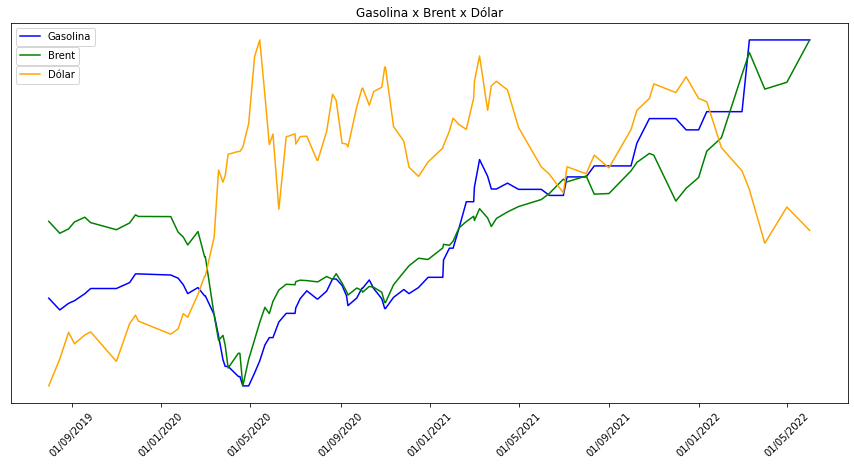

In [48]:
#grafico

fig, ax1 = plt.subplots(figsize=(15, 7))

plt.title("Gasolina x Brent x Dólar")

ax1.plot(df['Data'], df['Gasolina (BRL/L)'], label="Gasolina", color="blue")
ax1.legend()
ax1.get_yaxis().set_visible(False)
ax1.set_xticklabels(df['Data'], rotation=45)

ax2 = ax1.twinx()
ax2.plot(df['Data'], df['Brent (USD/bbl)'], label="Brent", color="green")
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.axis('off')

ax3 = ax1.twinx()
ax3.plot(df['Data'], df['Dólar (BRL/USD)'], label="Dólar", color="orange")
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax3.axis('off')

dtFmt = mdates.DateFormatter('%d/%m/%Y')
plt.gca().xaxis.set_major_formatter(dtFmt)

plt.show()

**Conclusão:** Conforme podemos observar no gráfico, o preço da gasolina tem seguindo a tendência da cotação do barril de petróleo, mas não podemos fazer a mesma correlação direta com a cotação do dólar.